# Download data

In [ ]:
!wget "https://github.com/MuseumofModernArt/collection/raw/master/Artworks.csv"
!wget "https://github.com/MuseumofModernArt/collection/raw/master/Artists.csv"

In [2]:
import pandas as pd
import numpy as np

# Create pandas dataframe
artworks = pd.read_csv("Artworks.csv")
artists = pd.read_csv("Artists.csv")

# MOMA Artists

### Gender distribution

In [3]:
artists.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN


In [4]:
artists["Gender"].value_counts()

Male          9715
Female        2342
male            17
Non-Binary       2
female           1
Non-binary       1
Name: Gender, dtype: int64

In [5]:
# Приведем к единообразию значения
artists["Gender"] = artists["Gender"].str.lower()
artists["Gender"].value_counts()

male          9732
female        2343
non-binary       3
Name: Gender, dtype: int64

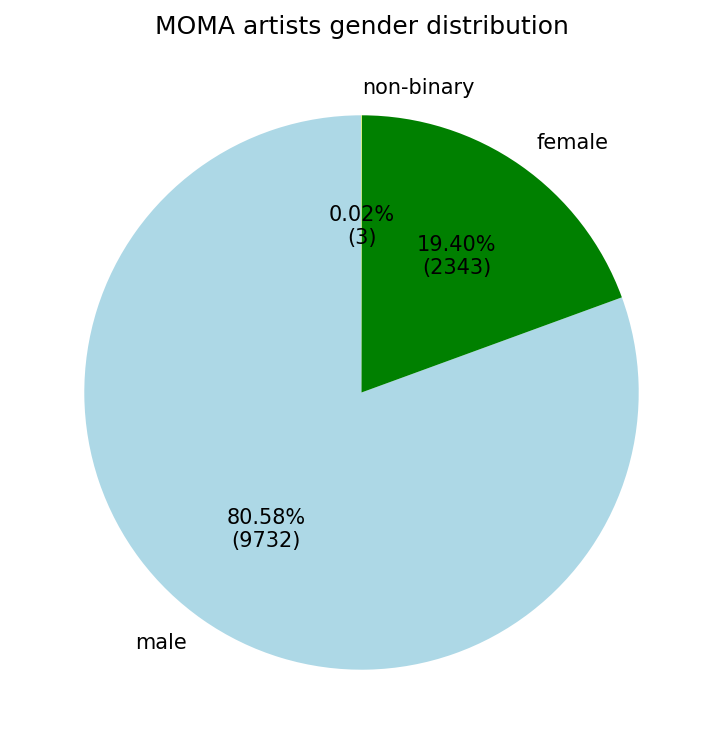

In [6]:
# Посмотрим какого пола художники
import matplotlib.pyplot as plt

colors = ["lightblue", "green", "yellow"]

def autopct_format(pct, values):
    total = sum(values)
    percentage = '{:.2f}%'.format(pct)
    absolute = '{:.0f}'.format(pct * total / 100)
    return f'{percentage}\n({absolute})'

gender = artists["Gender"].value_counts()

plt.figure(figsize=(12, 6), dpi=150)
plt.pie(gender.values, labels=gender.index, autopct=lambda pct: autopct_format(pct, gender.values), startangle=90, colors = colors)
plt.title("MOMA artists gender distribution")

# Display both values and percentages on the plot
plt.show()

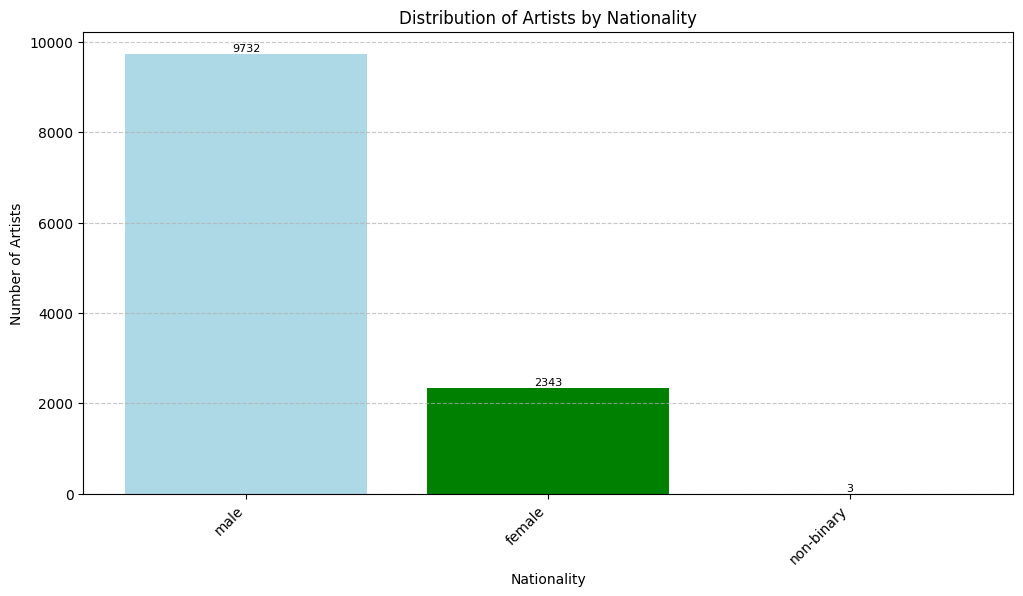

In [7]:
# Count the occurrences of each nationality, top 15
gender_counts = artists['Gender'].value_counts().head(15)

colors = ["lightblue", "green", "yellow"]

plt.figure(figsize=(12, 6))
# Plotting the histogram
plt.bar(gender_counts.index, gender_counts.values, color = colors)

plt.xlabel('Nationality')
plt.ylabel('Number of Artists')
plt.title('Distribution of Artists by Nationality')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adding numbers on top of each bar
for i, v in enumerate(gender_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=8)

# Adding a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
artworks["Classification"].value_counts().head(10)

Photograph                   34126
Print                        32143
Illustrated Book             27491
Drawing                      14630
Design                       12133
Architecture                  3828
Mies van der Rohe Archive     3434
Painting                      2394
Video                         2301
Sculpture                     1745
Name: Classification, dtype: int64

In [9]:
# Drop values with non id to merge tables
artworks = artworks[artworks["ConstituentID"].notna()]
artworks['ConstituentID'] = artworks['ConstituentID'].str.split(',').str[0]

# Convert 'ConstituentID' column to 'int64'
artworks['ConstituentID'] = artworks['ConstituentID'].astype('int64')

df_artworks_merged = pd.merge(artworks, artists, how="left", on=["ConstituentID"])
df_artworks_merged = df_artworks_merged[df_artworks_merged["Gender_y"].notna()]

#df_artworks_merged

clear data to work with it

In [10]:
date_column = df_artworks_merged["Date"]

# Handle None values
df_artworks_merged["Date"] = date_column.replace(None)

# Replace 'c. 1917' with the numeric part ('1917' in this case)
df_artworks_merged["Date"] = df_artworks_merged["Date"].str.extract('(\d+)').fillna(0)

# Drop rows with values like "1984-1985"
invalid_values = df_artworks_merged["Date"].astype(str).str.contains('-')
df_artworks_merged = df_artworks_merged[~invalid_values]

# Convert the remaining valid values to integers
df_artworks_merged["Date"] = df_artworks_merged["Date"].astype(int)

# Drop values with non real mean (less than 197)
invalid_values = df_artworks_merged["Date"] < 197
df_artworks_merged = df_artworks_merged[~invalid_values]

# Now, df_artworks_merged["Date"] contains only integer values without invalid values and None values


In [11]:
# Creating dataframes by types drawing, print, photograph
df_drawing = df_artworks_merged[df_artworks_merged["Classification"] == "Drawing"]
df_print = df_artworks_merged[df_artworks_merged["Classification"] == "Print"]
df_photo = df_artworks_merged[df_artworks_merged["Classification"] == "Photograph"]

In [12]:
# Limiting the size to more realistic by discarding outliers.
df_drawing = df_drawing[(df_drawing["Width (cm)"] > 2) & (df_drawing["Width (cm)"] < 1000)]
df_drawing = df_drawing[(df_drawing["Height (cm)"] > 2) & (df_drawing["Height (cm)"] < 1000)]

# Add the drawing size
df_drawing["Square m2"] = df_drawing["Width (cm)"] * df_drawing["Height (cm)"] / 10000

In [13]:
# Pivot table with statistics

height = df_drawing[(df_drawing["Date"] >= 1900)].groupby(["Classification", "Gender_y"]).agg({
    "ConstituentID": ["count"],
    "Height (cm)": ["min", "max", "median", "mean"],

})
width = df_drawing[(df_drawing["Date"] >= 1900)].groupby(["Classification", "Gender_y"]).agg({
    "ConstituentID": ["count"],
    "Width (cm)": ["min", "max", "median", "mean"],

})
square = df_drawing[(df_drawing["Date"] >= 1900)].groupby(["Classification", "Gender_y"]).agg({
    "ConstituentID": ["count"],
    "Square m2": ["min", "max", "median", "mean"],

})

In [14]:
height.to_csv("height.csv")
width.to_csv("width.csv")
square.to_csv("square.csv")

In [15]:
width

ConstituentID Width (cm)                        \
                                count        min        max     median   
Classification Gender_y                                                  
Drawing        female            2192   3.175006  744.85649  31.750064   
               male             11402   2.200000  814.70000  27.940100   

                                    
                              mean  
Classification Gender_y             
Drawing        female    49.894165  
               male      39.656666

In [16]:
square

ConstituentID Square m2                               
                                count       min        max    median      mean
Classification Gender_y                                                       
Drawing        female            2192  0.001210  19.930232  0.116717  0.445095
               male             11402  0.001122  22.844188  0.089675  0.256473

In [17]:
# Finding the largest painting

from IPython.display import display, Image
most_big = df_drawing[df_drawing["Square m2"] == max(df_drawing["Square m2"])]["URL"]
image_url = most_big #artworks.iloc[2]["ThumbnailURL"]
print(image_url)

df_drawing[df_drawing["Square m2"] == max(df_drawing["Square m2"])]

34433    http://www.moma.org/collection/works/36585
Name: URL, dtype: object


,Title,Artist,ConstituentID,ArtistBio_x,Nationality_x,BeginDate_x,EndDate_x,Gender_x,Date,Medium,...,Duration (sec.),DisplayName,ArtistBio_y,Nationality_y,Gender_y,BeginDate_y,EndDate_y,Wiki QID,ULAN,Square m2
34433,To Be With Art Is All We Ask...,"Gilbert & George, Gilbert Proesch, George Pass...",7496,"(British) (British, born Italy 1943) (British,...",(British) (British) (British),(0) (1943) (1942),(0) (0) (0),(Male) (Male) (Male),1970,Triptych: Charcoal and wash on partially charr...,...,NaN,Gilbert & George,British,British,male,0,0,Q684974,500055847.0,22.844188


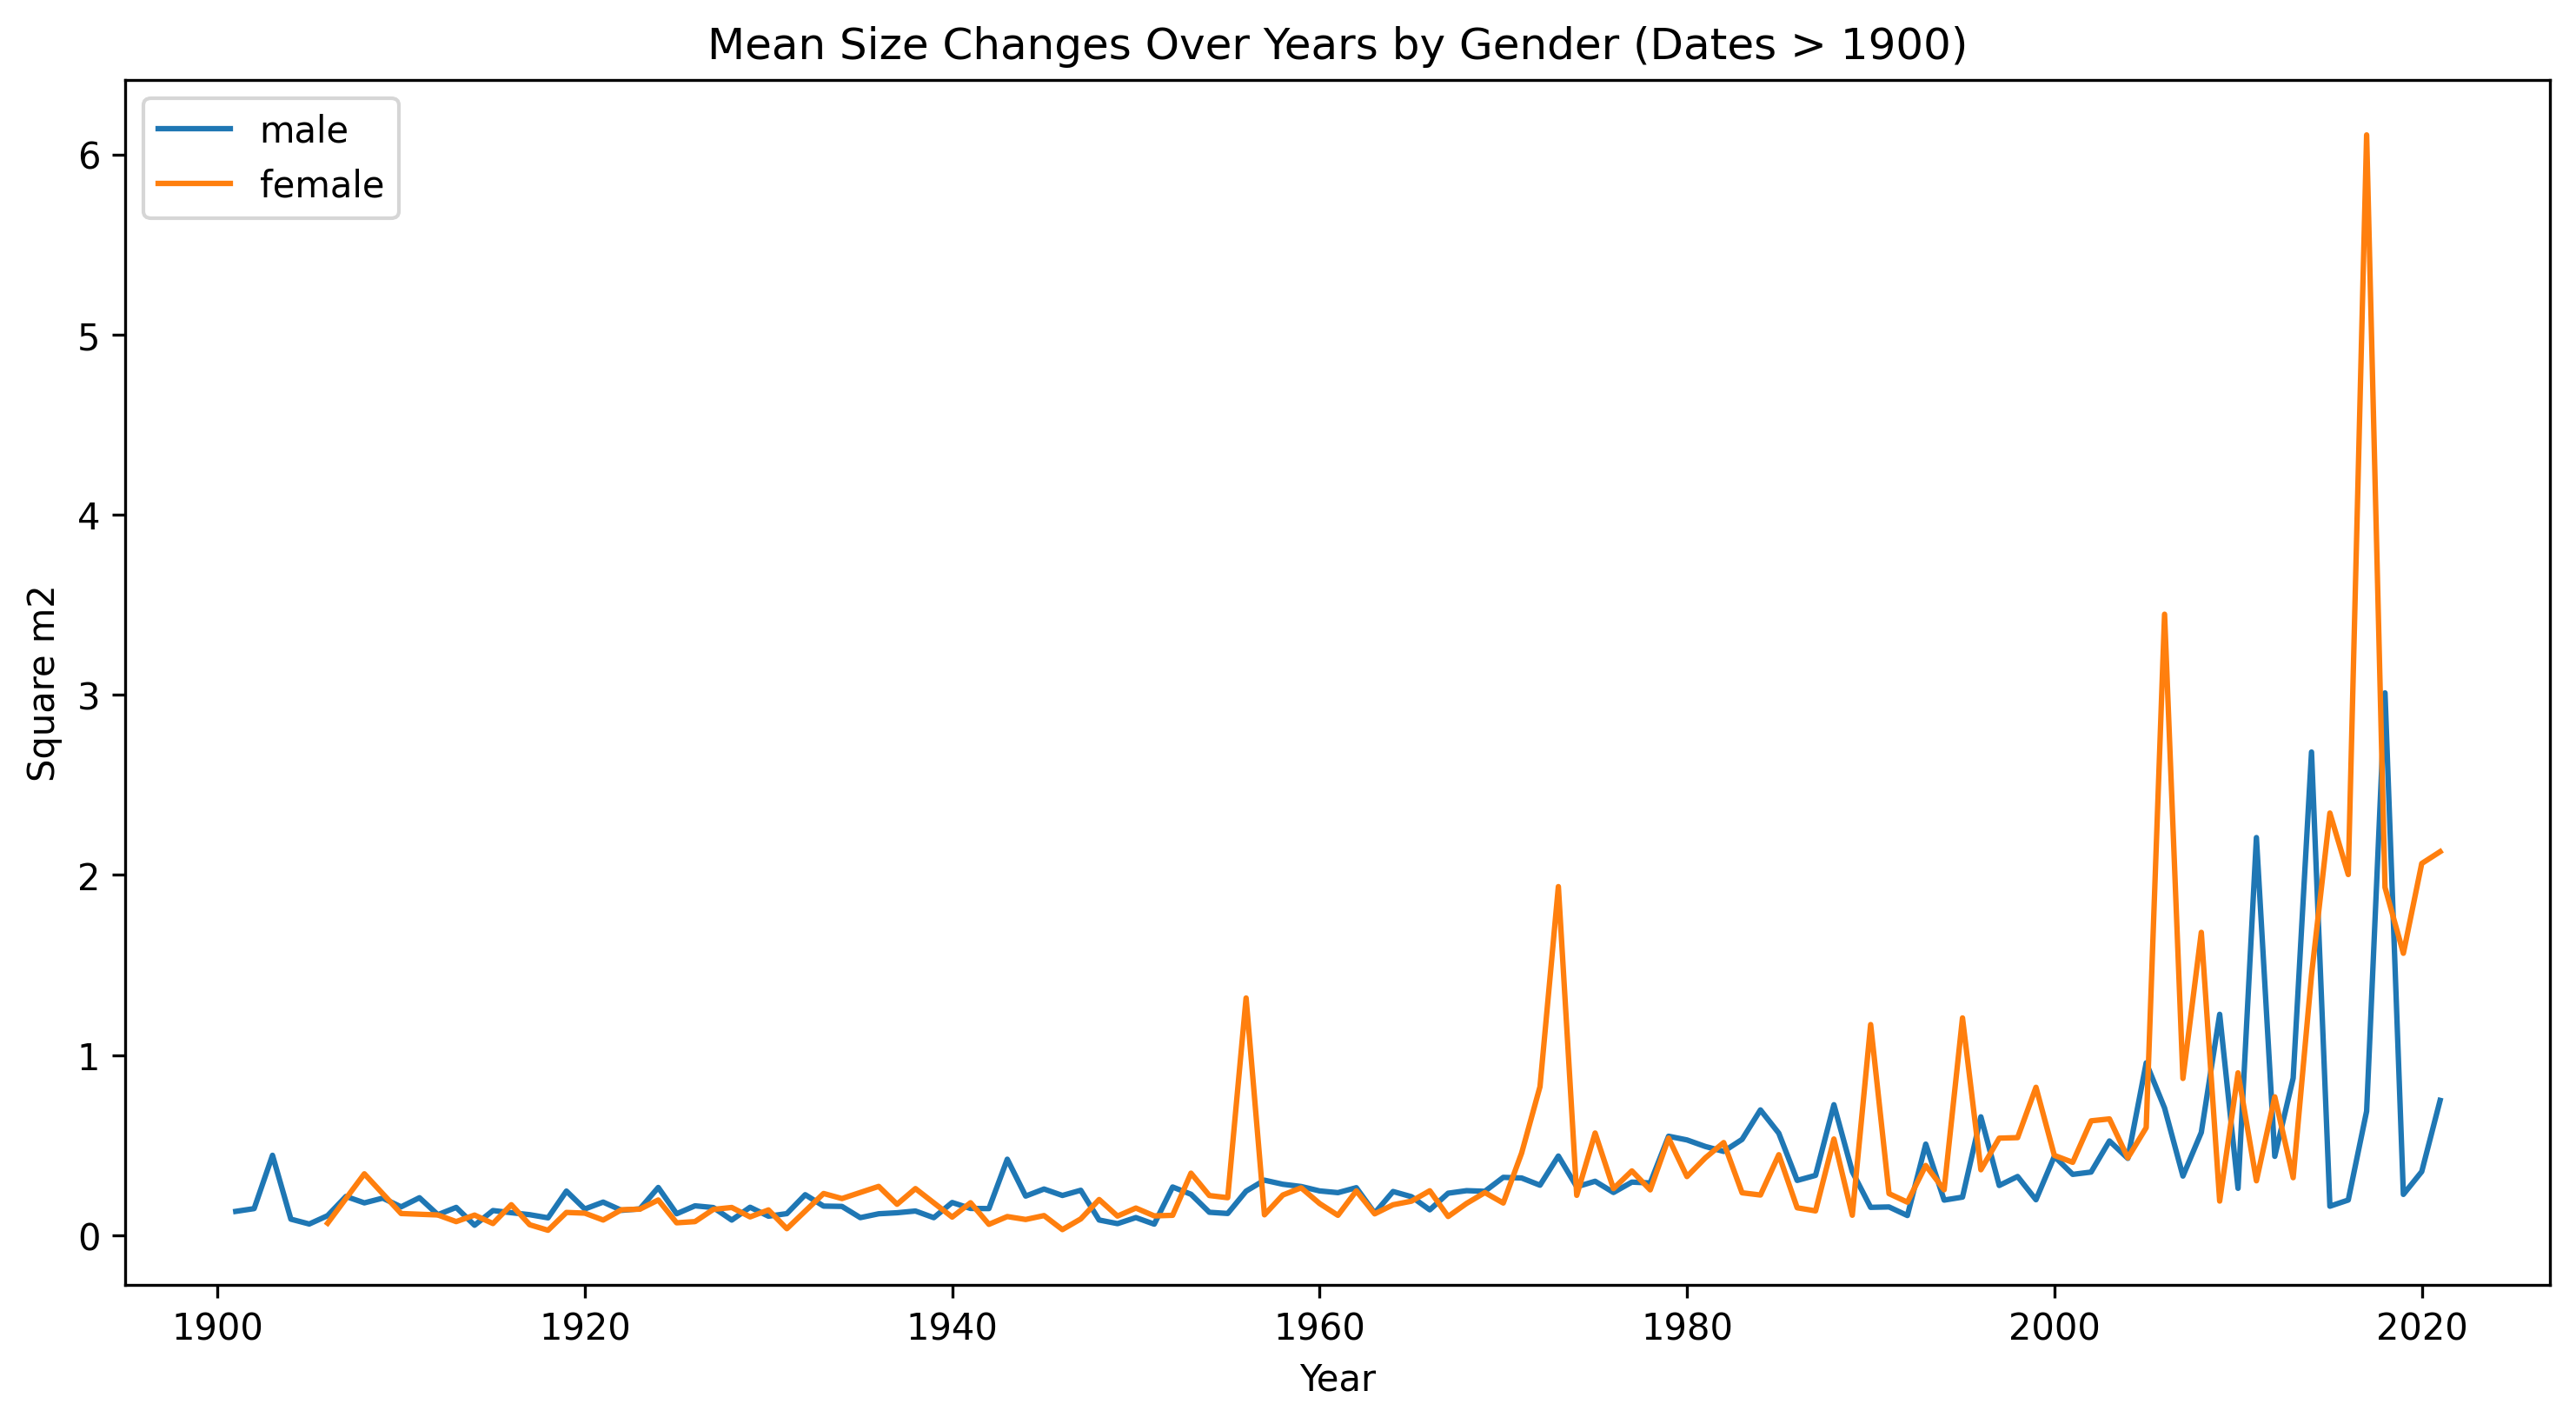

In [18]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
filtered_data = df_drawing[df_drawing['Date'] > 1900]

grouped_data = filtered_data.groupby(['Date', 'Gender_y'])['Square m2'].agg(['median', 'mean']).reset_index()

# Plotting with Seaborn and Matplotlib
plt.figure(figsize=(12, 6), dpi = 300)
#sns.lineplot(x='Date', y='mean', hue='Gender_y', data=grouped_data, label='Mean')
sns.lineplot(x='Date', y='mean', hue='Gender_y', data=grouped_data)

plt.title('Mean Size Changes Over Years by Gender (Dates > 1900)')
plt.xlabel('Year')
plt.ylabel('Square m2')
plt.legend()
plt.show()

In [19]:
# Group by year and calculate count, mean, and median
result = filtered_data.groupby('Date')['Square m2'].agg(['count', 'mean', 'median']).reset_index()

# Rename columns for clarity
result.columns = ['Year', 'Count', 'Mean Square m2', 'Median Square m2']

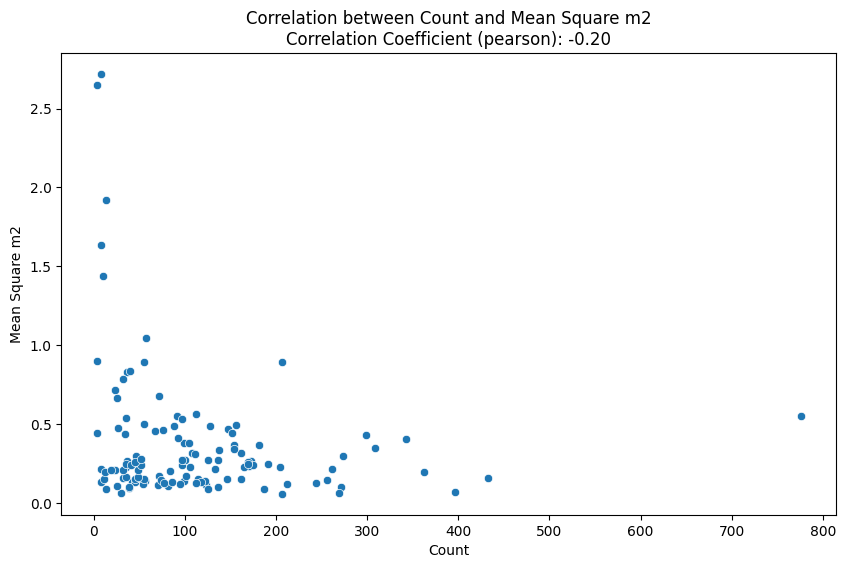

In [20]:
# Calculate correlation coefficient
correlation_coefficient, _ = pearsonr(result['Count'], result['Mean Square m2'])
spearman_coefficient, _ = spearmanr(result['Count'], result['Mean Square m2'])

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Count', y='Mean Square m2', data=result)

# Adding labels and title
plt.title(f'Correlation between Count and Mean Square m2\nCorrelation Coefficient (pearson): {correlation_coefficient:.2f}')
plt.xlabel('Count')
plt.ylabel('Mean Square m2')

# Display the plot
plt.show()


In [21]:
correlation_coefficient

-0.1565982649172952

A Pearson correlation coefficient of -0.2 signifies a weak negative linear correlation between two variables. This suggests that as one variable increases, the other decreases, albeit not very strongly. The correlation may exist because the exhibition size is constrained by space. If exhibits are broken down by year, more works can be accommodated when they are smaller.

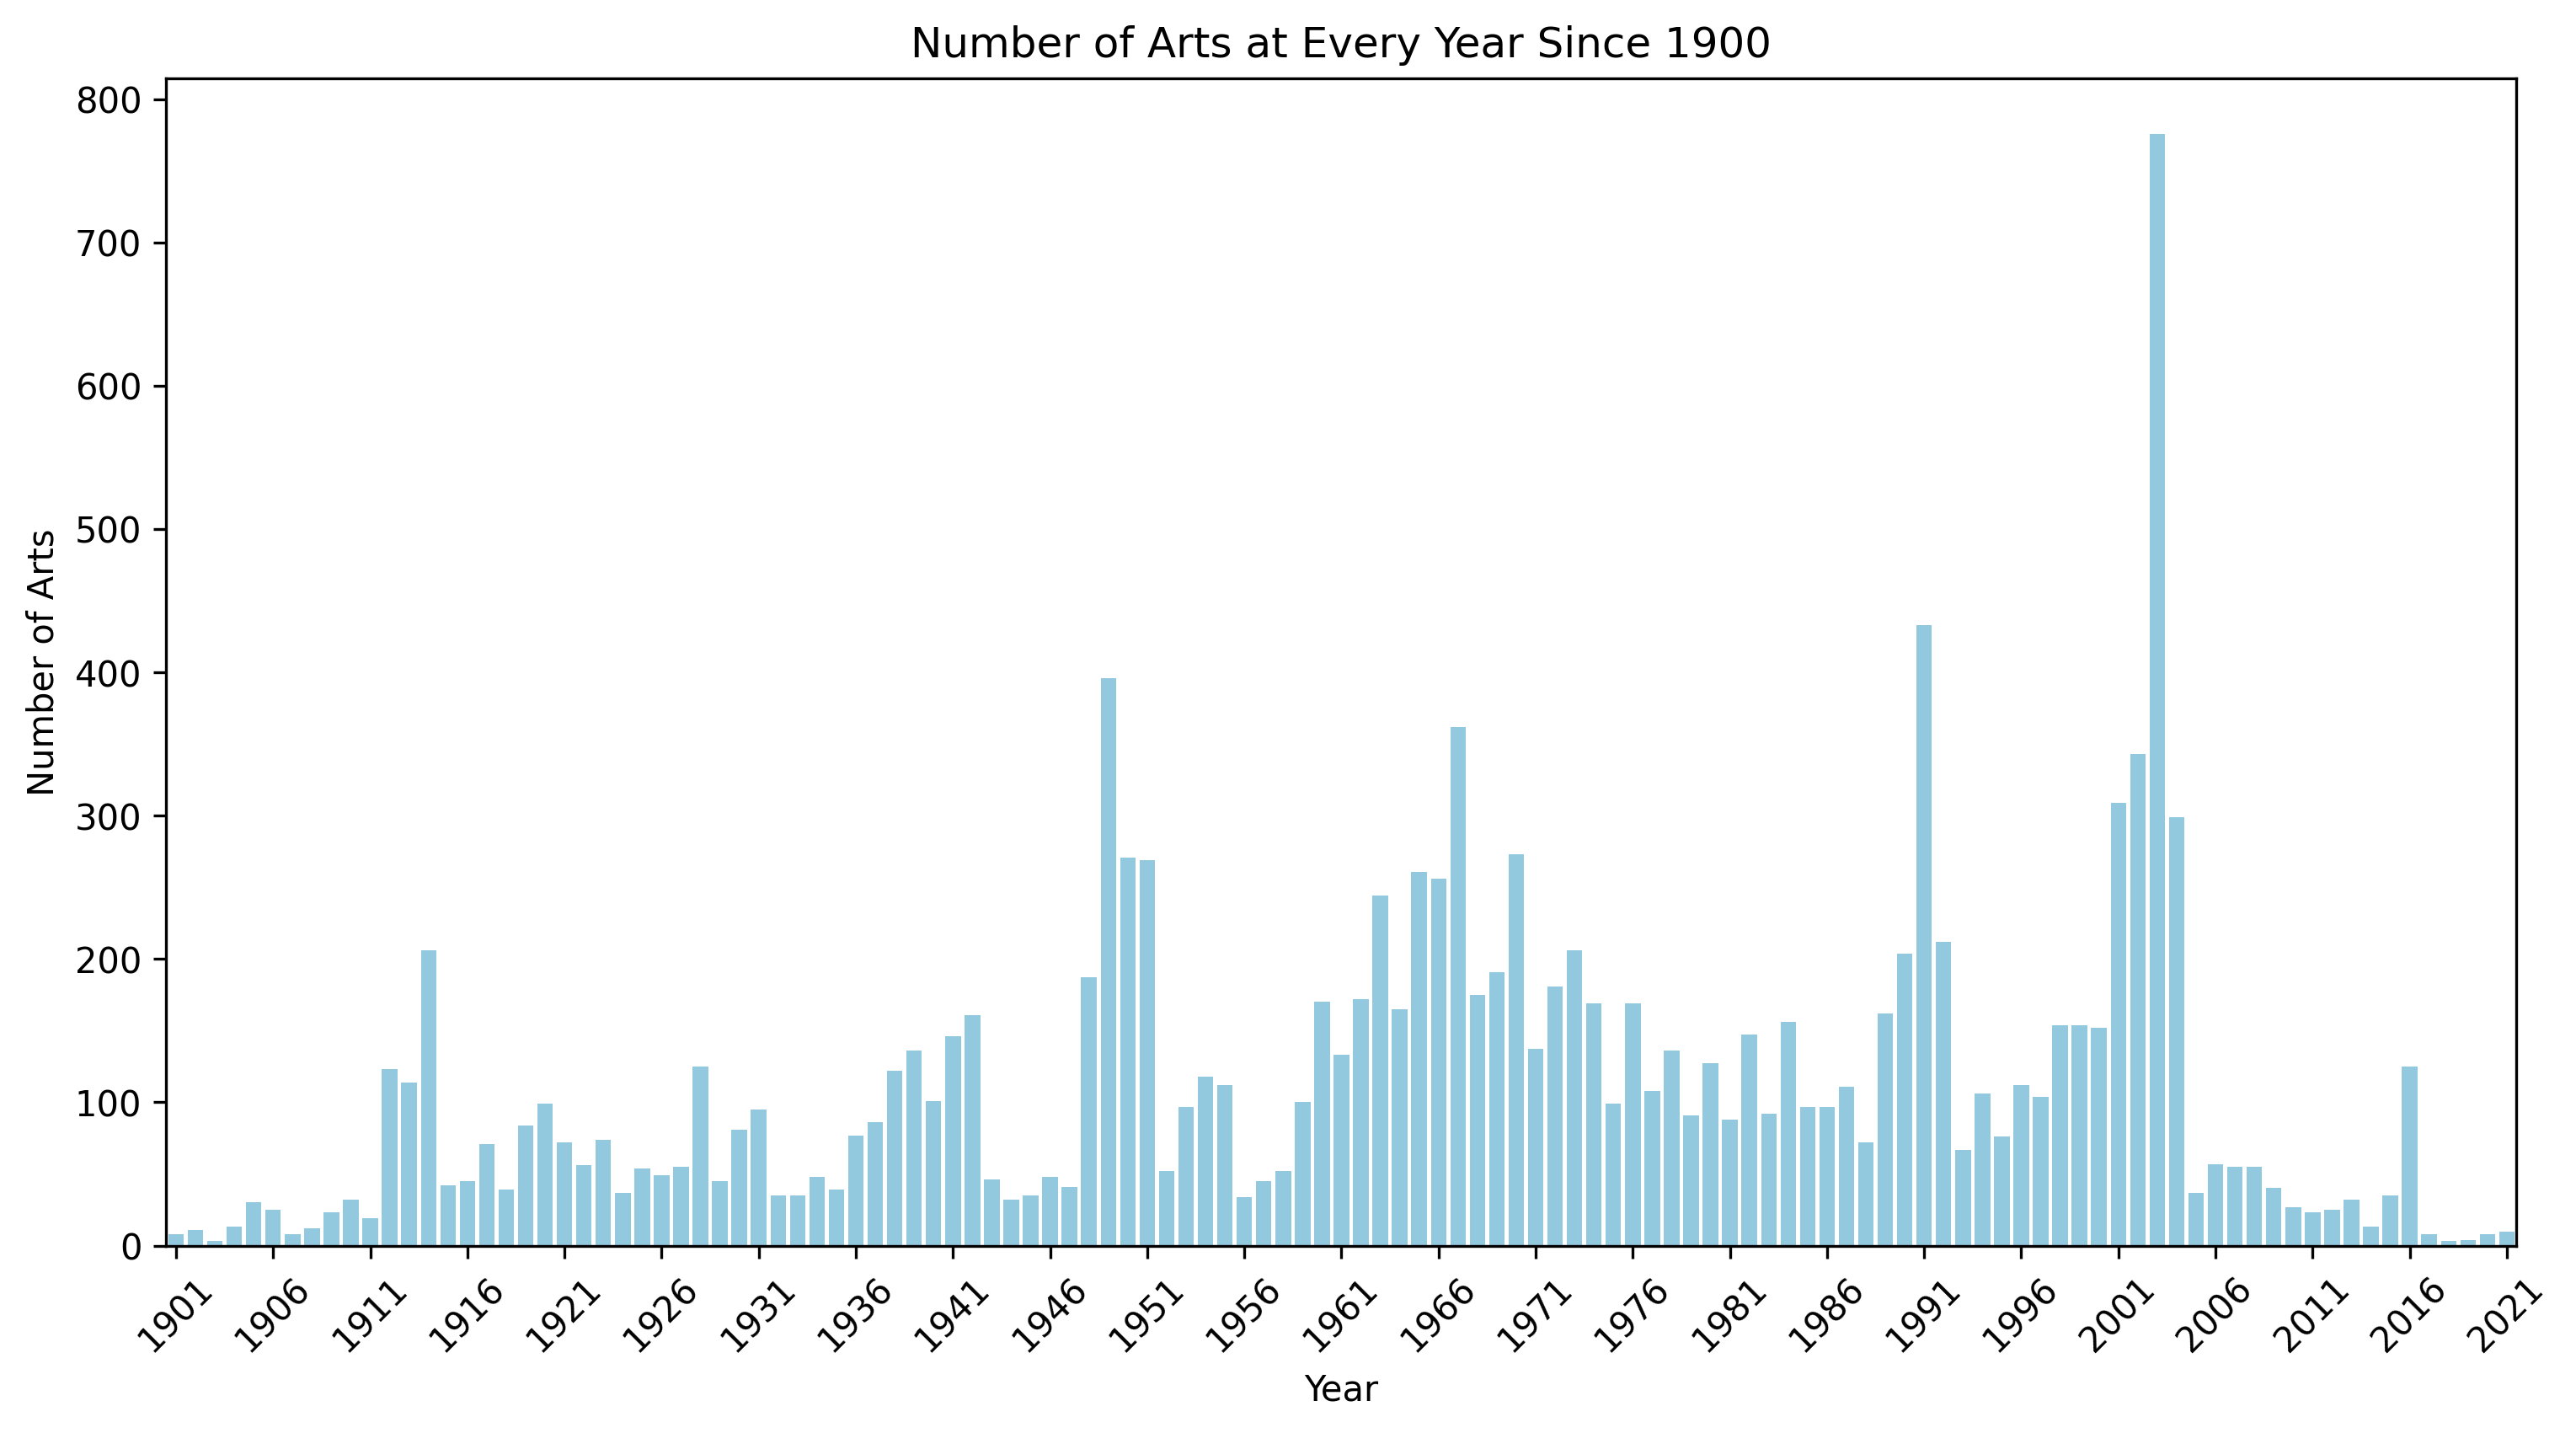

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filtered_data = df_drawing[df_drawing['Date'] > 1900]

# Count the number of arts for each year
arts_count_by_year = filtered_data.groupby('Date').size().reset_index(name='Arts Count')

# Plotting with Seaborn and Matplotlib
plt.figure(figsize=(12, 6), dpi = 300)
sns.barplot(x='Date', y='Arts Count', data=arts_count_by_year, color='skyblue')

plt.title('Number of Arts at Every Year Since 1900')
plt.xlabel('Year')
plt.ylabel('Number of Arts')
plt.xticks(rotation=45)

# Discretize the x-axis ticks by 5 years
plt.xticks(plt.xticks()[0][::5])

plt.show()


## Nationality

In [23]:
artists['Nationality'].value_counts().head(15)

American               5181
German                  965
British                 860
French                  847
Italian                 536
Japanese                507
Swiss                   297
Dutch                   274
Russian                 262
Austrian                239
Canadian                189
Brazilian               167
Nationality unknown     161
Spanish                 157
Argentine               142
Name: Nationality, dtype: int64

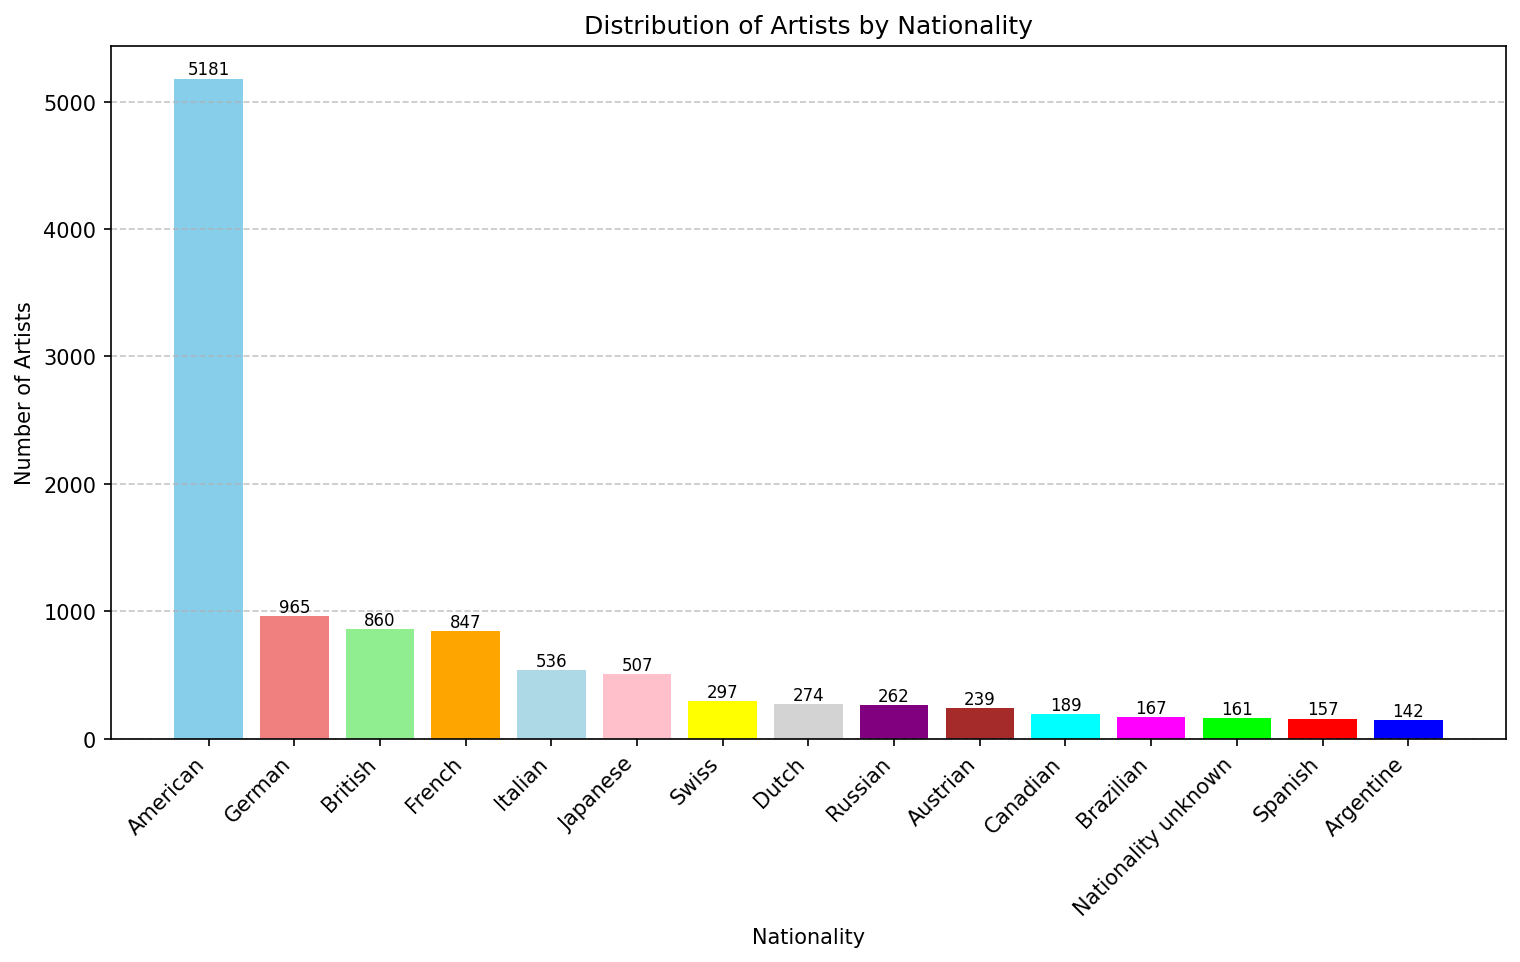

In [24]:
## TOP 15 NATIONALITY

import matplotlib.pyplot as plt
import pandas as pd

# Count the occurrences of each nationality, top 15
nationality_counts = artists['Nationality'].value_counts().head(15)


# Define different colors for each bar
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'lightblue', 'pink',
          'yellow', 'lightgray', 'purple', 'brown', 'cyan', 'magenta', 'lime', 'red', 'blue']

plt.figure(figsize=(12, 6), dpi=150)
# Plotting the histogram
plt.bar(nationality_counts.index, nationality_counts.values, color=colors)

plt.xlabel('Nationality')
plt.ylabel('Number of Artists')
plt.title('Distribution of Artists by Nationality')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adding numbers on top of each bar
for i, v in enumerate(nationality_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=8)

# Adding a grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The bar chart above suggests that the MoMA primarily exhibits paintings by American authors. The sequence that follows likely aligns with the cultural impact of artists from other countries on America.

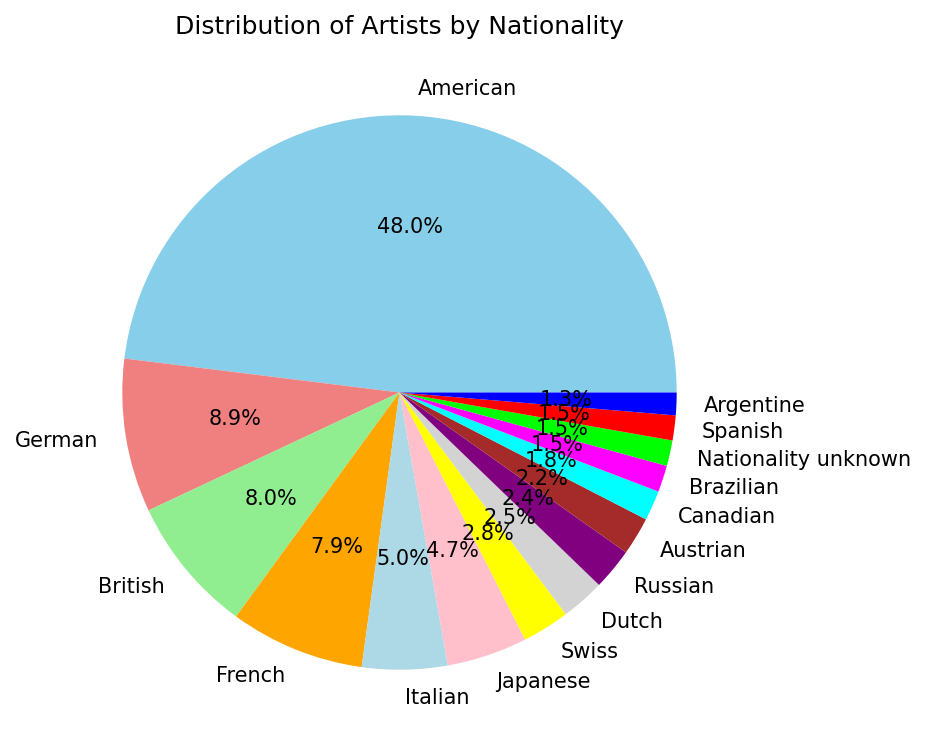

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the occurrences of each nationality, top 15
nationality_counts = artists['Nationality'].value_counts().head(15)

# Define different colors for each slice
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'lightblue', 'pink',
          'yellow', 'lightgray', 'purple', 'brown', 'cyan', 'magenta', 'lime', 'red', 'blue']

plt.figure(figsize=(12, 6), dpi=150)

# Plotting the pie chart
pie = plt.pie(nationality_counts, labels=nationality_counts.index, autopct='%1.1f%%', colors=colors, startangle=00)
#plt.pie(nationality_counts, labels=nationality_counts.index, autopct='%1.1f%%', colors=colors, startangle=140,
#        labeldistance=1.05, pctdistance=0.85, wedgeprops=dict(width=0.4))
plt.title('Distribution of Artists by Nationality')
#for text in pie[1]:
#    text.set_rotation(-45)
plt.show()


In this section, we used the non-missing birth date and death date to calculated the artists survival age, then use the histogram graph to show the age distribution.

In [26]:
import pandas as pd
import plotly.express as px


# Filter artists with BeginDate > 0
painter = artists[artists['BeginDate'] > 0]

# Filter artists with BeginDate > 0 and EndDate > 0
age = artists[(artists['BeginDate'] > 0) & (artists['EndDate'] > 0)]

# Calculate age
age['age'] = age['EndDate'] - age['BeginDate']

# Plot histogram
fig = px.histogram(age, x='age', opacity=0.6, nbins=30, color = "Gender", color_discrete_sequence=["#aaddff", "#edbacd"],
                   labels={'age': 'Age', 'count': 'Count'},
                   title='MOMA Artists Age Distribution')

fig.update_layout(yaxis_title='Count', height=600)  # Adjust the height value as needed

# Show the plot
fig.show()


<ipython-input-26-6eadf2e3e90b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age['age'] = age['EndDate'] - age['BeginDate']


<ipython-input-27-30903b6a7b43>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



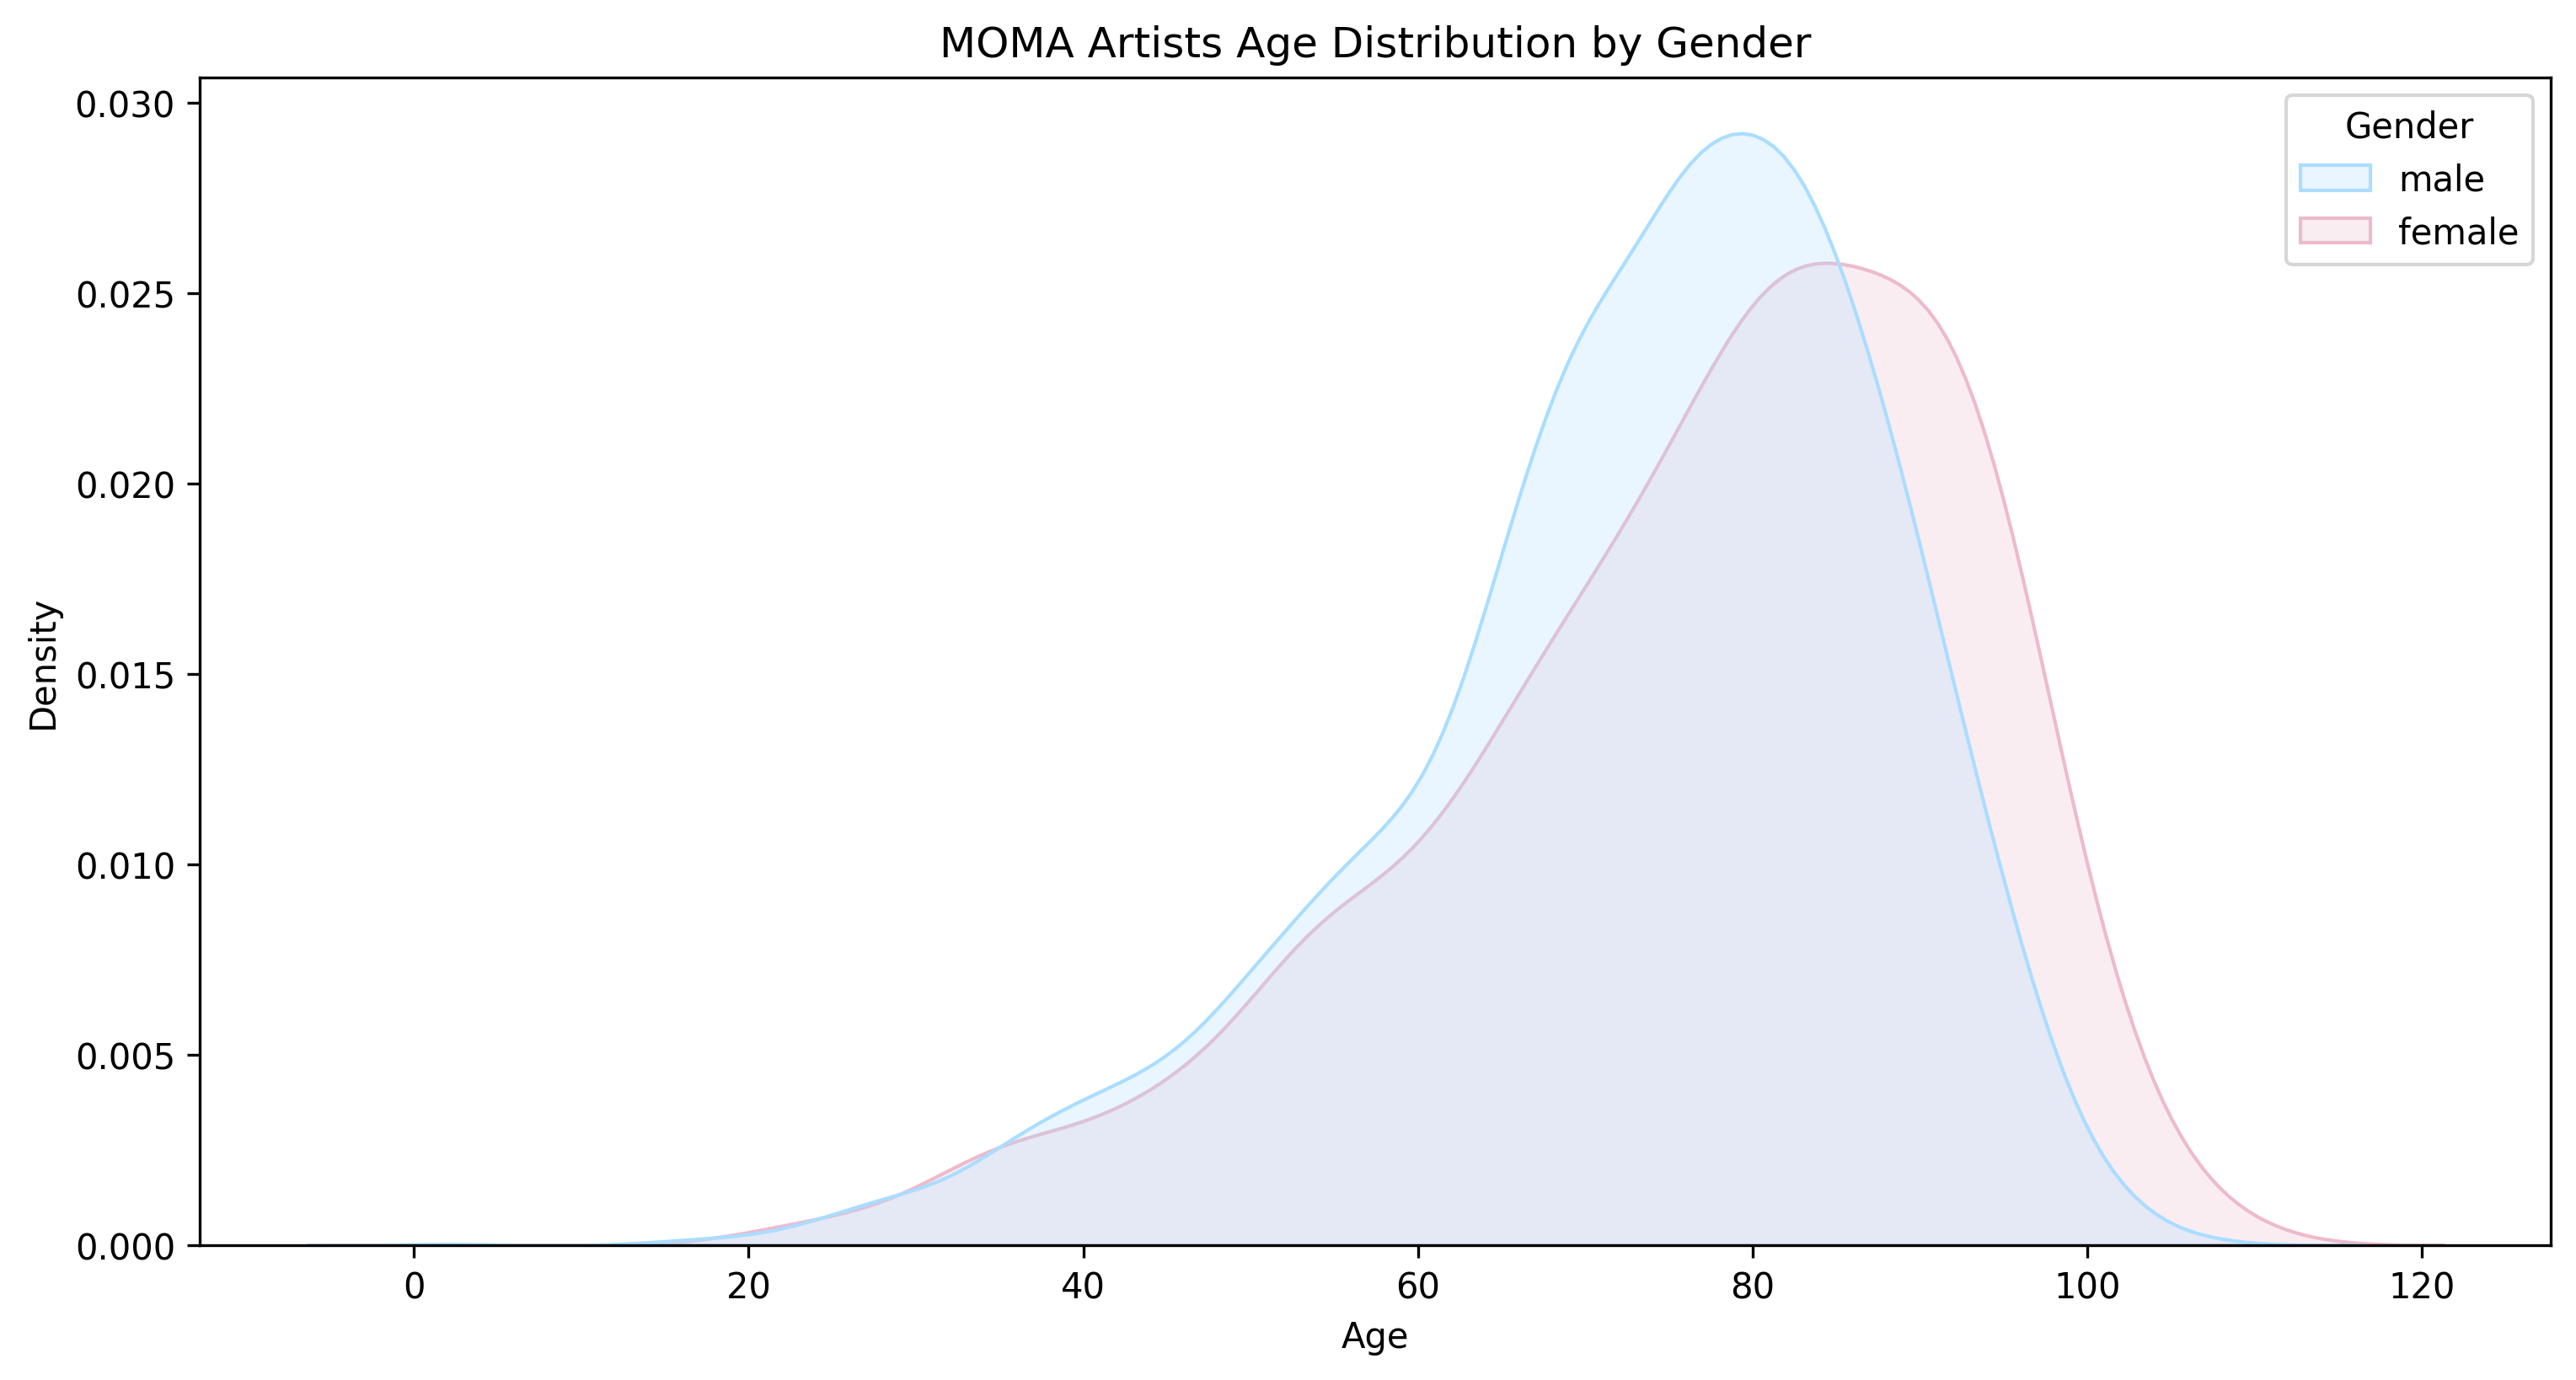

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Filter artists with BeginDate > 0 and Gender is not null
valid_artists = artists[(artists['BeginDate'] > 0) & artists['Gender'].notnull()]

# Filter artists with BeginDate > 0 and EndDate > 0
age = valid_artists[(valid_artists['BeginDate'] > 0) & (valid_artists['EndDate'] > 0)]

# Calculate age
age['age'] = age['EndDate'] - age['BeginDate']

# Create a KDE plot split by gender
plt.figure(figsize=(12, 6), dpi=300)
sns.kdeplot(data=age, x='age', hue='Gender', fill=True, common_norm=False, palette=["#aaddff", "#edbacd"])
plt.title('MOMA Artists Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

This graph shows that female artists on average live longer than male. However this is not specific to artists, it applies to the general population of men and women as well.

# Artworks

In [28]:
artworks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139632 entries, 0 to 140847
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Title               139618 non-null  object 
 1   Artist              139632 non-null  object 
 2   ConstituentID       139632 non-null  int64  
 3   ArtistBio           135023 non-null  object 
 4   Nationality         139632 non-null  object 
 5   BeginDate           139632 non-null  object 
 6   EndDate             139632 non-null  object 
 7   Gender              139632 non-null  object 
 8   Date                137807 non-null  object 
 9   Medium              130283 non-null  object 
 10  Dimensions          130874 non-null  object 
 11  CreditLine          137776 non-null  object 
 12  AccessionNumber     139632 non-null  object 
 13  Classification      139631 non-null  object 
 14  Department          139632 non-null  object 
 15  DateAcquired        133152 non-nul

In [29]:
artworks["Classification"].value_counts()

Photograph                        33943
Print                             31900
Illustrated Book                  27449
Drawing                           14599
Design                            12095
Architecture                       3825
Mies van der Rohe Archive          3434
Painting                           2393
Video                              2266
Sculpture                          1743
Multiple                           1151
Installation                        872
Frank Lloyd Wright Archive          821
Audio                               756
Periodical                          743
Ephemera                            537
(not assigned)                      482
Work on Paper                       259
Film                                154
Poster                               43
Media                                34
Performance                          30
Textile                              30
Notebook                             27
Collage                              24


# EDA

In [30]:
# Lets choose drawing
#df = artworks[(artworks["Classification"] == "Drawing") & (artworks["Department"] == "Drawings & Prints")]
df = artworks

In [31]:
#Lets look at most presentable artists
top15 = pd.DataFrame(df["Artist"].value_counts().head(15))
top15
# Pivot table

,Artist
Eugène Atget,5050
Louise Bourgeois,3336
Unidentified photographer,2738
Ludwig Mies van der Rohe,2657
Jean Dubuffet,1435
Lee Friedlander,1320
Pablo Picasso,1310
Ellsworth Kelly,1232
Marc Chagall,1161
Henri Matisse,1064


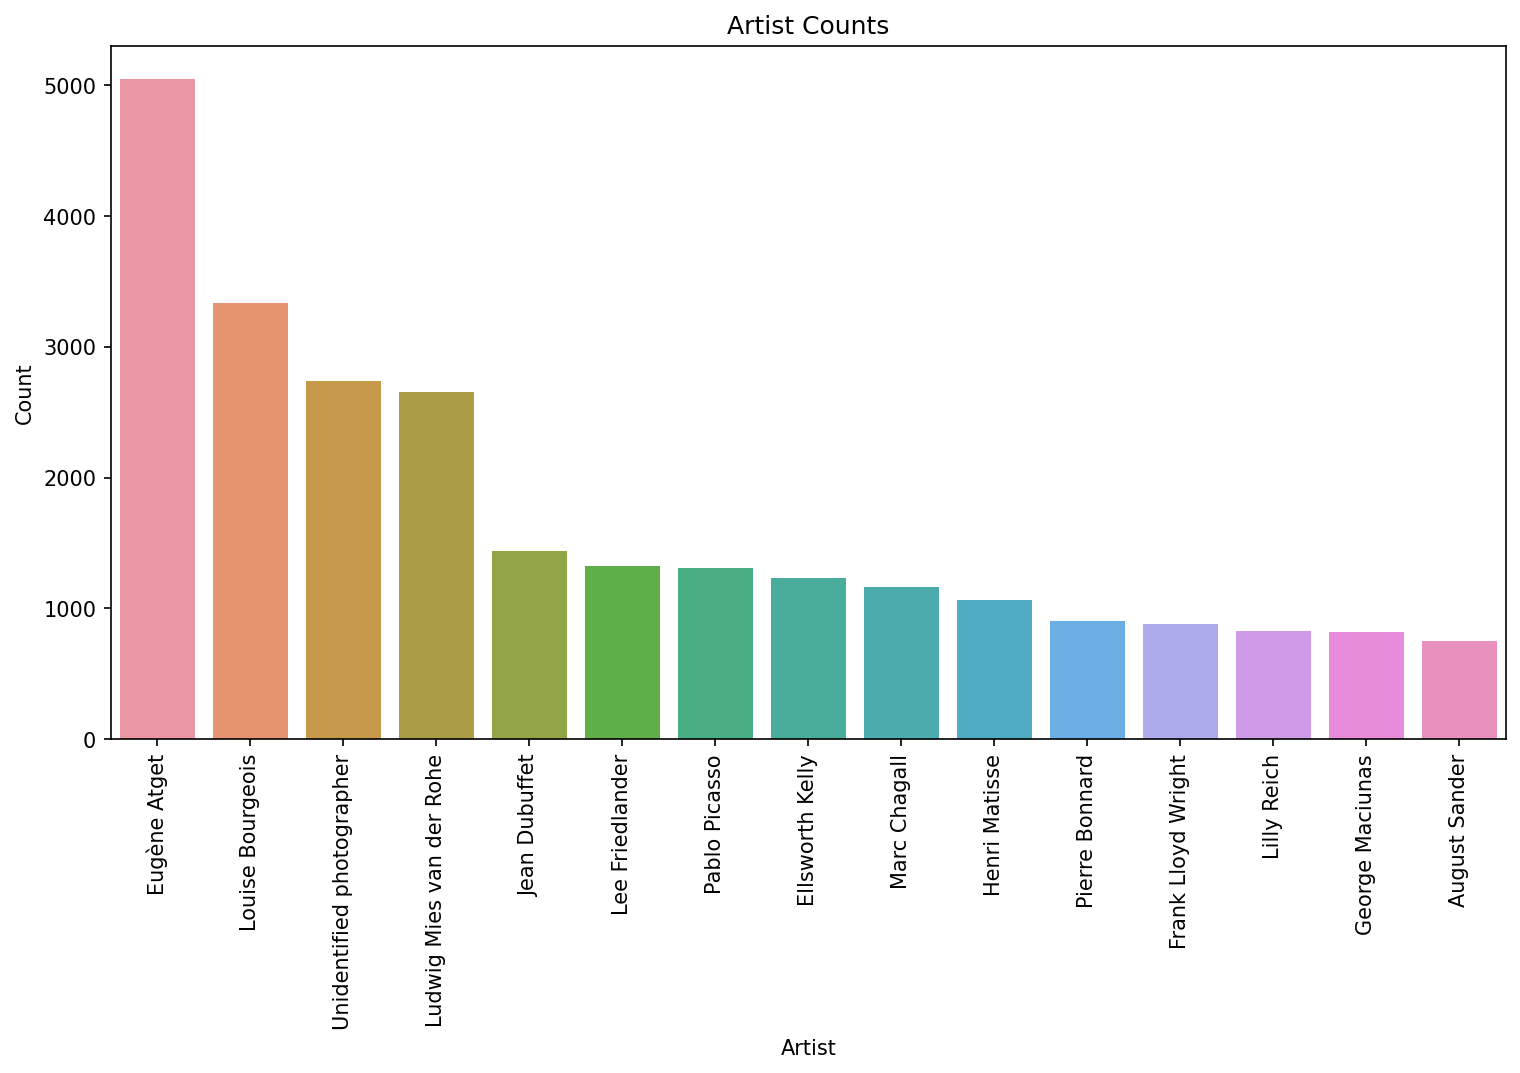

In [32]:
# Top 15 artists
import seaborn as sns
import matplotlib.pyplot as plt

# Create a histogram using Seaborn
plt.figure(figsize=(12, 6), dpi=150)
sns.countplot(x='Artist', data=df, order=df['Artist'].value_counts().head(15).index)
plt.title('Artist Counts')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.xticks(rotation=90, )  # Rotate x-axis labels by 45 degrees

plt.show()


## Word cloud

Here we are going to visualize the distribution of artists in the dataset using a word cloud.

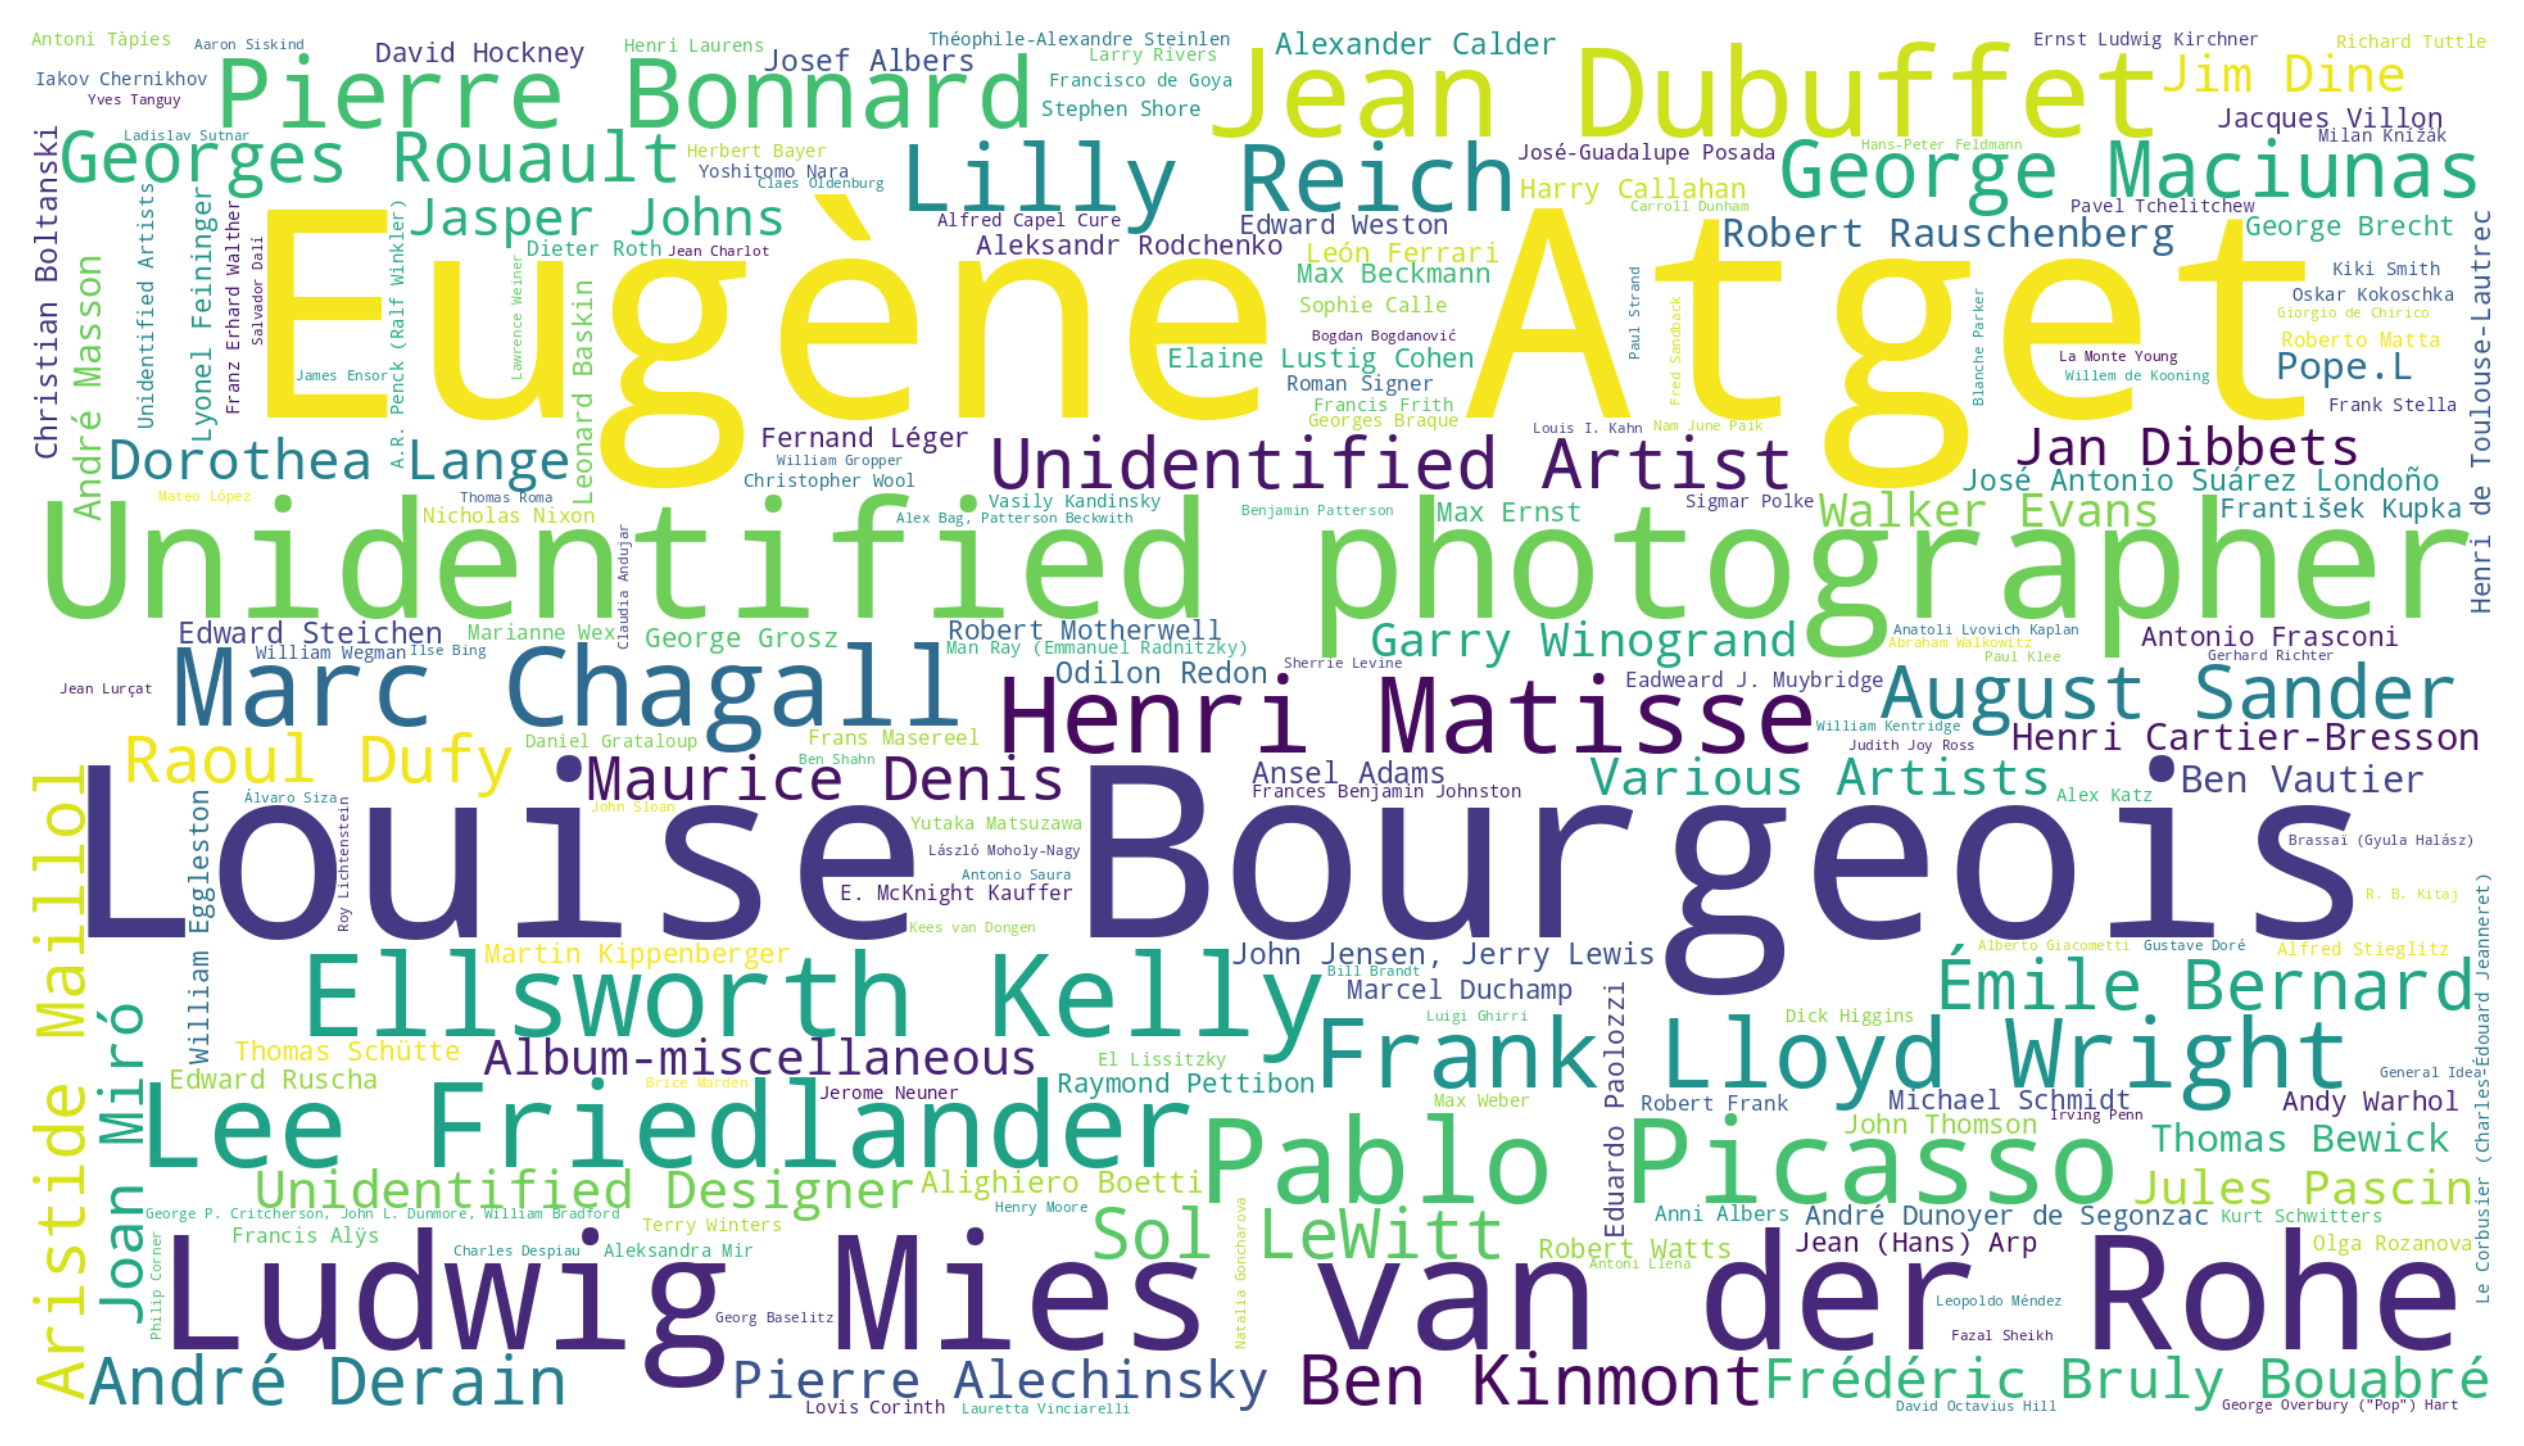

In [33]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all text into a single string
all_text = ' '.join(df[df["Artist"].notna()]['Artist'])

# Generate word cloud
#wordcloud = WordCloud(width=1920, height=1080, background_color='white', contour_width=2, contour_color='steelblue').generate(all_text)

wordcloud = WordCloud(
    width=1920, height=1080, background_color='white', contour_width=2, contour_color='steelblue'
).generate_from_frequencies(
    df[df["Artist"].notna()]['Artist'].value_counts()
)

# Plot the WordCloud image
plt.figure(figsize=(12, 6), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The word cloud visually represents the frequency of artists in the dataset, with font size indicating occurrence. Eugène Atget, Louise Bourgeois, and Ludwig Mies van der Rohe are most mentioned, hinting at their cultural significance. The font size gives an instant visual summary of the artistic presence in the dataset.

In [34]:
age.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN,age
0,1,Robert Arneson,"American, 1930–1992",American,male,1930,1992,NaN,NaN,62
9,11,Jean (Hans) Arp,"French, born Germany (Alsace). 1886–1966",French,male,1886,1966,Q153739,500031000.0,80
11,13,J. Arrelano Fischer,"Mexican, 1911–1995",Mexican,male,1911,1995,NaN,NaN,84
12,15,Folke Arstrom,"Swedish, 1907–1997",Swedish,male,1907,1997,NaN,NaN,90
13,16,Cristobal Arteche,"Spanish, 1900–1964",Spanish,male,1900,1964,NaN,NaN,64


### Lets try find relationship between work performed and life expectancy. Maybe artists with more number of works have older age

In [35]:
import pandas as pd

# Assuming you have two dataframes df and age
df = df[df["ConstituentID"].notna()]
#df['ConstituentID'] = df['ConstituentID'].str.split(',').str[0]

# Convert 'ConstituentID' column to 'int64'
df['ConstituentID'] = df['ConstituentID'].astype('int64')

# Merge the dataframes on the "ConstituentID" column
merged_df = pd.merge(df, age, on="ConstituentID", how="left")

# Group by artist and calculate the number of works and the average age
result_df = merged_df.groupby("Artist").agg({"Title": "count", "age": "mean"}).reset_index()

# Rename the columns for clarity
result_df.columns = ["artist", "num_arts", "age"]

# Display the result
print(result_df)


                                                  artist  num_arts   age
0                                           "a.r." group         5   NaN
1      (follower of) José-Guadalupe  Posada, Manuel M...         1  61.0
2                                         11 bit studios         1   NaN
3                 2x4, Inc., Michael Rock, Susan Sellers         1   NaN
4                                     A B Norna Hemslojd         1   NaN
...                                                  ...       ...   ...
13691                                Étienne-Jules Marey         3  74.0
13692                Étienne-Jules Marey, Georges Demeny         1  74.0
13693                       Ödön Palasovsky, Iván Hevesy         1  81.0
13694                                   Öyvind Fahlström        21  48.0
13695                                    Øistein Thurman         1   NaN

[13696 rows x 3 columns]


In [36]:
rd = result_df[result_df["age"].notna()]

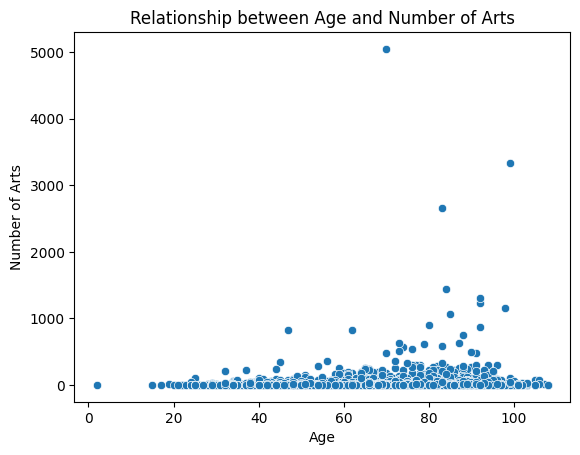

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot
sns.scatterplot(x="age", y="num_arts", data=rd)

# Set plot labels and title
plt.xlabel("Age")
plt.ylabel("Number of Arts")
plt.title("Relationship between Age and Number of Arts")

# Show the plot
plt.show()


In [38]:
# Calculate correlation coefficient
correlation = rd["age"].corr(rd["num_arts"])

# Print the correlation coefficient
print(f"Correlation coefficient between age and num_arts: {correlation}")

Correlation coefficient between age and num_arts: 0.035627483897802466


A coefficient close to 0 suggests a weak or no linear correlation. Changes in one variable are not associated with consistent changes in the other variable. It can also be interpreted that in this sample there is no linear relationship between the age of the artist and the number of his works presented in this museum. This means we cannot say that if the artist lived longer, it means he had more time to engage in art and do a large number of works.

In [39]:
rd = result_df[result_df["age"].notna()]

# Single painting

In [40]:
# Lets visualise something
from IPython.display import display, Image
import random

#random_index = random.choice(list(df.index))
random_index = random.choice(list(df.index))
image_url = df["ThumbnailURL"][random_index]

# Print info
for col in df.columns:
    print(col," : ", df[col][random_index])

# Display the image
if type(image_url) == str:
    display(Image(url=image_url))



Title  :  Videos de Castillito: Ciudad Guayana
Artist  :  Margarita D'Amico, Manuel Manzano
ConstituentID  :  35913
ArtistBio  :  nan
Nationality  :  () ()
BeginDate  :  (0) (0)
EndDate  :  (0) (0)
Gender  :  (Female) (Male)
Date  :  1979
Medium  :  Video (color, sound)
Dimensions  :  27 min.
CreditLine  :  Gift of the artists
AccessionNumber  :  477.1982
Classification  :  Video
Department  :  Media and Performance
DateAcquired  :  1982-10-04
Cataloged  :  Y
ObjectID  :  122321
URL  :  http://www.moma.org/collection/works/122321
ThumbnailURL  :  nan
Circumference (cm)  :  nan
Depth (cm)  :  nan
Diameter (cm)  :  nan
Height (cm)  :  nan
Length (cm)  :  nan
Weight (kg)  :  nan
Width (cm)  :  nan
Seat Height (cm)  :  nan
Duration (sec.)  :  1620.0


In [41]:
artworks.head()

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.)
0,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,6210,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,...,http://www.moma.org/media/W1siZiIsIjUyNzc3MCJd...,NaN,NaN,NaN,48.6000,NaN,NaN,168.9000,NaN,NaN
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,7470,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,...,http://www.moma.org/media/W1siZiIsIjUyNzM3NCJd...,NaN,NaN,NaN,40.6401,NaN,NaN,29.8451,NaN,NaN
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...",...,http://www.moma.org/media/W1siZiIsIjUyNzM3NSJd...,NaN,NaN,NaN,34.3000,NaN,NaN,31.8000,NaN,NaN
3,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,...,http://www.moma.org/media/W1siZiIsIjUyNzQ3NCJd...,NaN,NaN,NaN,50.8000,NaN,NaN,50.8000,NaN,NaN
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, color pencil, ink, and gouache on tr...",...,http://www.moma.org/media/W1siZiIsIjUyNzQ3NSJd...,NaN,NaN,NaN,38.4000,NaN,NaN,19.1000,NaN,NaN


In [42]:
from IPython.display import display, Image

image_url = artworks.iloc[2]["ThumbnailURL"]

# Display the image
display(Image(url=image_url))